In [ ]:
!pip install pandas scikit-learn


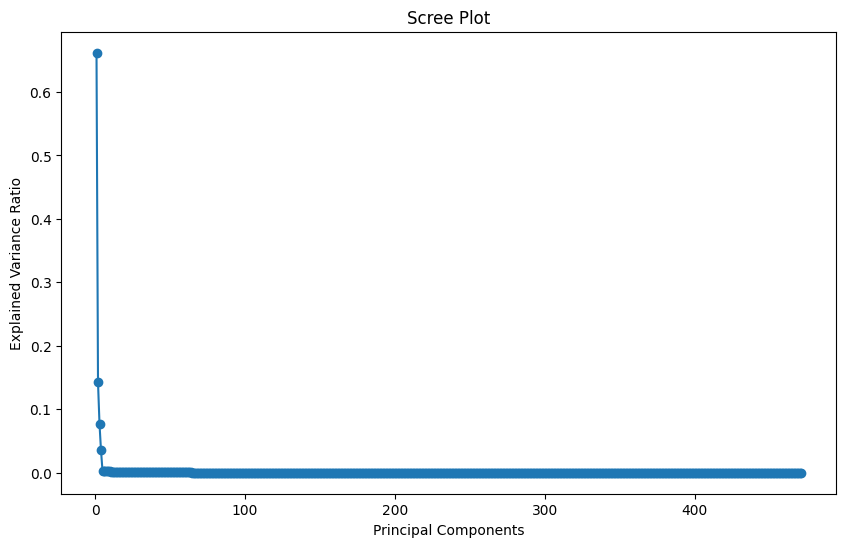

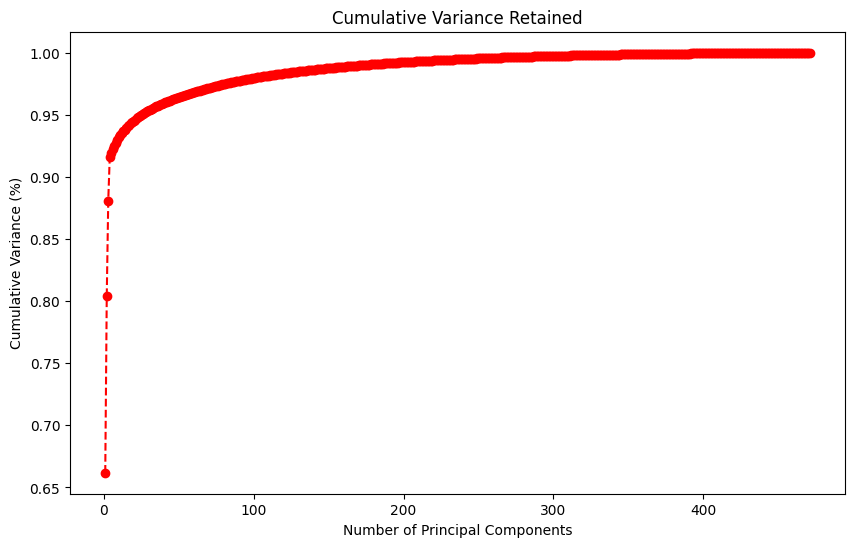

number of principal components to retain 80% of total variance: 2


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# load data
df = pd.read_csv('SP500_close_price_no_missing.csv')

# (a) return log returns
returns = np.log(df.iloc[:, 1:] / df.iloc[:, 1:].shift(1))

# Drop the first row containing NaN values - from gpt, when included first row throws off graphs
returns = returns.dropna()

# (a) fit PCA model
pca = PCA()
pca.fit(returns)

# Plot scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()


# plot cumulative variance plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='r')
plt.title('Cumulative Variance Retained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance (%)')
plt.show()

# determine number of components to capture at min 80% of the tot variance
n_components_for_80 = np.argmax(cumulative_variance >= 0.8) + 1

print(f"number of principal components to retain 80% of total variance: {n_components_for_80}")


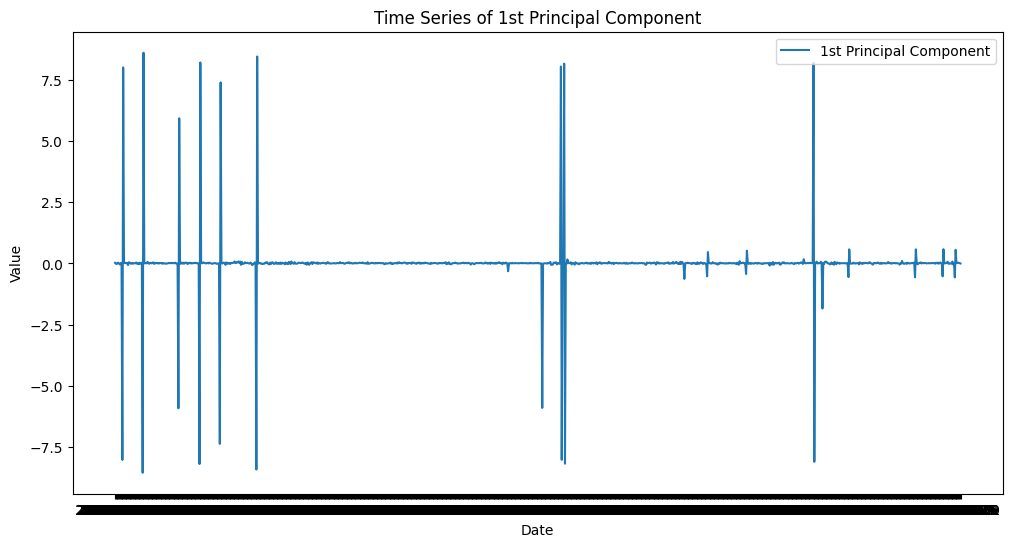

Date w/ lowest value for the 1st Principal component: 2011-02-21


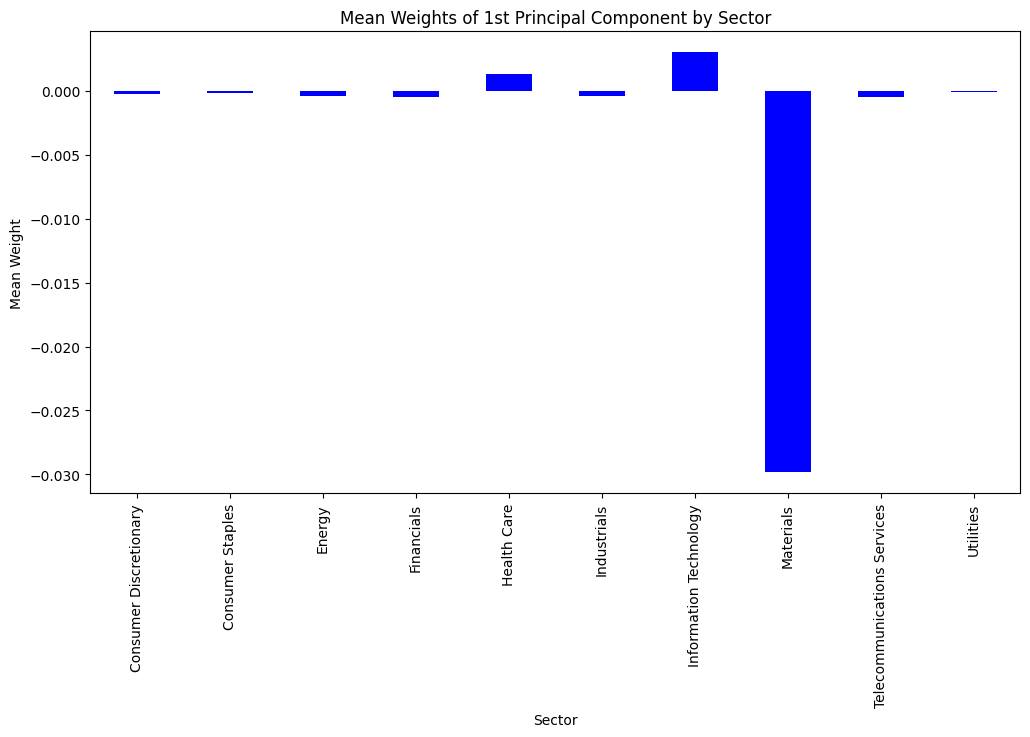

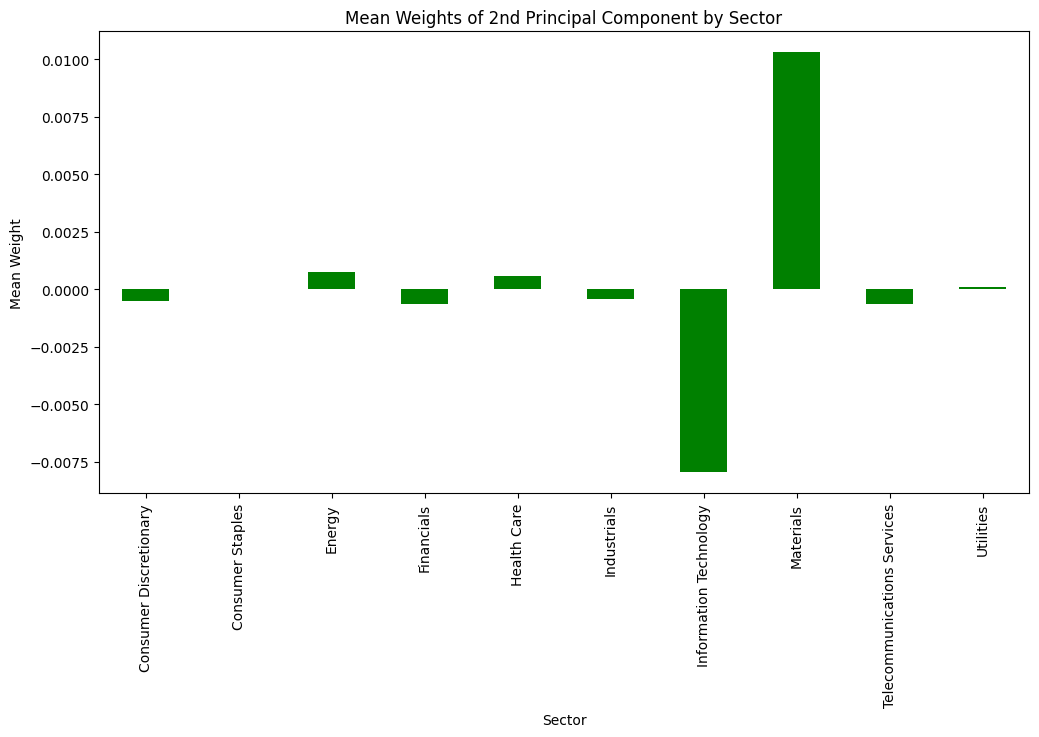

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


df = pd.read_csv('SP500_close_price_no_missing.csv')

sectors = pd.read_csv('SP500_ticker.csv')

# Derive log returns
log_returns = np.log(df.iloc[:, 1:] / df.iloc[:, 1:].shift(1))

# Drop NaN values created by the shift operation
log_returns = log_returns.dropna()

# Fit a PCA model
pca = PCA()
pca.fit(log_returns)

# 1 compute and plot the time series of the 1st principal component
pca_components = pca.transform(log_returns)
first_principal_component = pca_components[:, 0]

#figure
plt.figure(figsize=(12, 6))
plt.plot(df['date'].iloc[1:], first_principal_component, label='1st Principal Component')
plt.title('Time Series of 1st Principal Component')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# 1.1 Identify the date with the lowest value for the 1st principal component
lowest_value_date = df.loc[first_principal_component.argmin() + 1, 'date']
print(f'Date w/ lowest value for the 1st Principal component: {lowest_value_date}')


# 2 extract the weights from the PCA model for the 1 and 2 PCs
weights_1st_component = pca.components_[0]
weights_2nd_component = pca.components_[1]

# nerge weights with sector information based on tickers.csv file 
weights_df = pd.DataFrame({'Stock': df.columns[1:], 'Weight_1st_Component': weights_1st_component, 'Weight_2nd_Component': weights_2nd_component})
merged_df = pd.merge(weights_df, sectors, left_on='Stock', right_on='ticker', how='left')

# 3 Create a plot to show weights of the 1st principal component grouped by industry sector
mean_weights_by_sector_1st = merged_df.groupby('sector')['Weight_1st_Component'].mean()

#figure
plt.figure(figsize=(12, 6))
mean_weights_by_sector_1st.plot(kind='bar', color='blue')
plt.title('Mean Weights of 1st Principal Component by Sector')
plt.xlabel('Sector')
plt.ylabel('Mean Weight')
plt.show()

# 4 make a similar plot for the 2nd principal component
mean_weights_by_sector_2nd = merged_df.groupby('sector')['Weight_2nd_Component'].mean()

plt.figure(figsize=(12, 6))
mean_weights_by_sector_2nd.plot(kind='bar', color='green')
plt.title('Mean Weights of 2nd Principal Component by Sector')
plt.xlabel('Sector')
plt.ylabel('Mean Weight')
plt.show()


In [96]:

#BMI problems

import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load 
data = pd.read_csv('BMI.csv')

#seperate predictors (X) and target variable (y)
X = data.drop('fatpctg', axis=1)
y = data['fatpctg']

# Forward STep
def forward_selection(X, y):
    selected_features = []
    while len(selected_features) < X.shape[1]:
        remaining_features = list(set(X.columns) - set(selected_features))
        best_pvalue = float('inf')
        best_feature = None

        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            pvalue = model.pvalues[feature]
            if pvalue < best_pvalue:
                best_pvalue = pvalue
                best_feature = feature

        if best_feature is not None:
            selected_features.append(best_feature)
        else:
            break

    #fit the final model
    final_model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()
    return selected_features, final_model

selected_features_forward, final_model_forward = forward_selection(X, y)
print("Selected Features (Forward Stepwise):", selected_features_forward)
print("Final Model Summary (Forward Stepwise):")
print(final_model_forward.summary())

# Back Step
def backward_selection(X, y):
    selected_features = list(X.columns)
    while len(selected_features) > 0:
        model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_feature = pvalues.idxmax()

        if pvalues[worst_feature] > 0.05:
            selected_features.remove(worst_feature)
        else:
            break

    #Fit the final model
    final_model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()
    return selected_features, final_model

selected_features_backward, final_model_backward = backward_selection(X, y)
print("Selected Features (Backward Stepwise):", selected_features_backward)
print("Final Model Summary (Backward Stepwise):")
print(final_model_backward.summary())





#Calculate correlation on features and target variable
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['fatpctg'].abs().sort_values(ascending=False)

# Fit the final model
selected_features_filter = correlation_with_target.index[1:]  # Exclude the target variable
final_model_filter = sm.OLS(y, sm.add_constant(X[selected_features_filter])).fit()

print("Feature Ranking (Filter Method):")
print(correlation_with_target)
print("\nFinal Model Summary (Filter Method):")
print(final_model_filter.summary())




#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#fit lasso model
lasso_model = LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5)
lasso_model.fit(X_train_scaled, y_train)

#get selected features based on non-zero coefficients
selected_features_lasso = X.columns[lasso_model.coef_ != 0]

#fit the final model
final_model_lasso = sm.OLS(y_train, sm.add_constant(X_train[selected_features_lasso])).fit()

print("Selected Features (Lasso Regression):", selected_features_lasso)
print("\nFinal Model Summary (Lasso Regression):")
print(final_model_lasso.summary())






#fit a random forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

#get feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Fit the final model
selected_features_rf = feature_importances.index
final_model_rf = sm.OLS(y, sm.add_constant(X[selected_features_rf])).fit()

print("Feature Ranking (Random Forest):")
print(feature_importances)
print("\nFinal Model Summary (Random Forest):")
print(final_model_rf.summary())





Selected Features (Forward Stepwise): ['Abdomen', 'Weight', 'Wrist', 'Forearm', 'Neck', 'Age', 'Thigh', 'Hip', 'Height', 'Biceps', 'Ankle', 'Chest', 'Knee']
Final Model Summary (Forward Stepwise):
                            OLS Regression Results                            
Dep. Variable:                fatpctg   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     53.97
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           2.31e-63
Time:                        10:43:17   Log-Likelihood:                -719.43
No. Observations:                 252   AIC:                             1467.
Df Residuals:                     238   BIC:                             1516.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
             